In [1]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from torch.utils.data import Dataset, DataLoader
import glob
import json
from tqdm.notebook import tqdm
import torch.optim as optim
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

Using backend: pytorch


# Homework 3 - finding shortest path (edge classification)

### The data here is stored in 10,000 json files for each of the training/testing datasets

In [2]:
path_to_ds = 'training_data/'
path_to_test_ds = 'test_data/'

### the custom dataset object will load the json files, and then convert the graphs to DGL graphs

In [3]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        
        filelist = glob.glob(path+'/*.json')
        
        self.graphs = []
        for fname in tqdm(filelist):
            with open(fname) as jfile:
                graph = nx.node_link_graph(json.load(jfile))
                g = dgl.DGLGraph()
                g.from_networkx(graph,node_attrs=['node_features'],edge_attrs=['distance','on_path'])
                
                self.graphs.append(g)
        
        
    def __len__(self):
       
        return len(self.graphs)


    def __getitem__(self, idx):
        
    
        return self.graphs[idx], self.graphs[idx].edata['on_path']

### The node features are just 2 numbers - [0,0] for most nodes,
### and [1,0] for the start node, [0,1] for the end node
### the edges all have a property of "distance" which is essentially random
### and a label if they are on the shortest path or not

In [4]:
train_ds = CustomDataset(path_to_ds)
test_ds = CustomDataset(path_to_test_ds)

In [38]:
#train_ds[495][0].ndata['node_features'].numpy()

In [39]:
train_ds[495][0].edata

{'distance': tensor([1.5963, 1.6945, 1.7745, 0.2660, 1.1752, 1.2065, 2.0709, 0.0756, 0.4753,
        0.4146, 1.2827, 1.4618, 2.0145, 1.1744, 2.0031, 2.1266, 1.8650, 1.0908,
        0.6862, 1.3497, 1.0932, 1.5963, 0.4146, 2.0031, 1.5395, 1.1795, 1.4008,
        1.5250, 1.8174, 1.2065, 2.1266, 1.8650, 1.3497, 0.7326, 1.4008, 0.3539,
        2.0586, 0.0519, 2.0709, 0.0519, 1.1358, 0.1781, 2.0235, 1.6945, 2.0145,
        2.2567, 1.4520, 0.9753, 1.5715, 1.0114, 0.4753, 0.7326, 1.5766, 1.6729,
        1.8174, 0.0777, 0.5258, 0.5465, 1.7745, 0.5400, 0.1781, 0.6985, 0.2660,
        1.1752, 1.5395, 0.5258, 0.0756, 0.6862, 2.0586, 2.0235, 2.2567, 1.3174,
        1.4759, 1.5715, 0.0777, 1.6062, 1.4618, 1.1744, 1.0932, 1.1795, 1.5250,
        0.9753, 0.5465, 0.1992, 1.2827, 1.0114, 1.3174, 0.7618, 0.3539, 1.6729,
        0.7618, 1.8638, 1.1358, 1.4520, 0.5400, 1.4759, 1.6062, 1.3850, 1.0908,
        1.5766, 0.6985, 0.1992, 1.8638, 1.3850]), 'on_path': tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

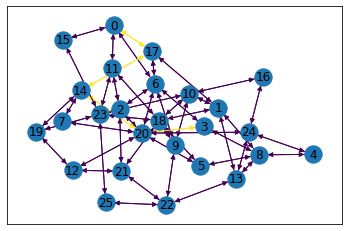

In [20]:
nx.draw_networkx( dgl.to_networkx(train_ds[495][0]) ,edge_color=train_ds[495][1].numpy())

In [43]:
dgl.batch??

In [47]:
torch.cat((torch.randn(3),torch.randn(3)))

tensor([ 0.2347, -0.2909, -1.1974,  2.0217,  0.0203, -1.9722])

In [37]:
def collate(samples):
    
    # The input `samples` is a list, a batch of whatever comes out of your dataset object
    
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    
    batched_graph = dgl.batch(graphs,node_attrs=['node_features'],edge_attrs=['distance'])
    targets = torch.cat(labels)
    
    return batched_graph, targets.unsqueeze(1).float()

In [44]:
import torch.nn as nn
import torch.nn.functional as F


#this function is the edge update function - 

class EdgeNetwork(nn.Module):
    def __init__(self):
        super(EdgeNetwork, self).__init__()
        

        
    def forward(self, x):
        
        
        #your input x is an object with the following properties:
        #x.dst['node_features'], x.dst['node_hidden_state']
        #x.src['node_features'], x.src['node_hidden_state']
        #x.data['distance']
        # ^^^linked to 2 nodes + the data of the edge itself
        #put  all of the above them together with torch.cat
        
        #use a neural network to create an edge hidden represetation - 
        
        #you return a dictionary with what you want to "send" to the reciving node
        #This is the message that is sent to the nodes vv
        
        return {'edge hidden represetation': output }
    
    #2 hidden layers, 50 

    
class NodeNetwork(nn.Module):
    def __init__(self):
        super(NodeNetwork, self).__init__()

        
    def forward(self, x):
        
        #this time your input x has:
        # x.mailbox['edge hidden represetation'] -> this is what you send with the edge update function above - 
        # it will have the size of the node neighborhood - 
        # (Batch size, number of nodes in neighborhood, edge hidden rep size), so you need to sum/mean over dim=1 
        #               need to sum this ^^^ on the mail box dim=1 to concatenate
        #               concat with vv, put through fully connected network -> new node hidden state, return with dictionary
        # x.data['node_hidden_state'] and x.data['node_features'] (this is the existing state of your node)
        # you need to torch.cat the message sum, node hidden state, and node features 
        #- and then apply some fully connected neural network
        
        # return a new hidden state for the node
        return {'node_hidden_state': out }
    
    #2 hidden layers, 50


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        # you need to create a network that 
        # will initialize your node hidden state based only on the node features -
        self.node_init = nn.Sequential(
                #.... fully connected, a few linear layers.
                # Goes from node features (2 numbers) to hidden representation (We choose the size)
            
            nn.Linear(...,node_representation_size))
        
        self.edge_network = EdgeNetwork(...)
        self.node_network = NodeNetwork(...)
        
        #this edge classifier is also an edge update function - 
        #but it needs to return something of size 1 (the edge class prediction)
        #so either create a different model for this, or make the EdgeNetwork configurable
        self.edge_classifier = EdgeNetwork(...)
        
    def forward(self, g):
        
        g.ndata['node_hidden_state'] = self.node_init(g.ndata['node_features'])
        #First need to initialize the hidden state with the node features as input.
        
        for i in range(number of iterations):
            # the same gn block, apply it multiple times.
            # this is the way to do it:
            # edge function and node function - implement as nn's
            g.update_all(self.edge_network,self.node_network)
            
            #number of iterations - how far does each edge have to see to determine if its on the path
            # needs to be 5,6,10 - balance with results.
            # should take 20 mins of training
            
        
        #we want to classify the edges - so finally apply your edge classifier -
         
        g.apply_edges(self.edge_classifier)
        #^^ need to create another module like Edge network or configure it with outputsize,outputname and change what comes out
        #will have destination and source features for the nodes.
        
        #and extract its output 
        out = g.edata['edge_class_prediction']
        #                  ^^^^ this is the name of the message from the new module
        # whatever number of edges we have in the input dgl graph, the output should be the same size, should match the concatenated labels.

        
        return out 

SyntaxError: invalid syntax (<ipython-input-44-3dfd23b90b12>, line 70)

In [12]:
net = Classifier()

In [15]:
data_loader = DataLoader(train_ds, batch_size=30, shuffle=True,
                         collate_fn=collate)

In [20]:
loss_func = nn.BCEWithLogitsLoss()

In [4]:
for epoch in 
    for x,y in data_loader:
        
        x = x.to(torch.device('cuda'))
        y = y.cuda()
        
        

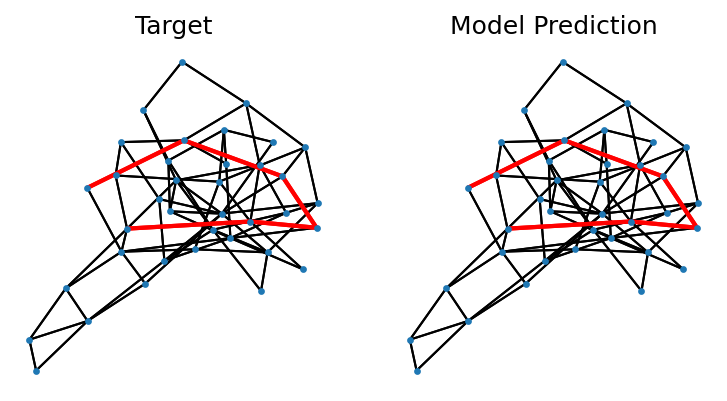

In [67]:
from scipy.special import expit, logit

fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].set_title('Target')
ax[1].set_title('Model Prediction')

net.eval()
net.cpu()

dgl_g = test_ds[5578][0]

output_pred = net(dgl_g).data.numpy()

nx_graph = dgl.to_networkx(dgl_g)
pos = {i: dgl_g.ndata['node_features'][i][:2].data.numpy() for i in range(len(dgl_g.ndata['node_features']))} #nx.spring_layout(nx_graph)
edge_list = [e for i,e in enumerate(nx_graph.edges) if dgl_g.edata['on_path'][i]==1]

edge_widths = np.array([expit(output_pred[i][0]) for i in range(len(output_pred))])
predicted_edge_list = [e for i,e in enumerate(nx_graph.edges) if expit(output_pred[i])[0]>=0.5]

pos = nx.spring_layout(nx_graph)


nx.draw( nx_graph ,pos=pos ,ax=ax[0] ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=edge_list,width=2,edge_color='r',ax=ax[0],arrows=False)

nx.draw( nx_graph ,pos=pos ,ax=ax[1] ,node_size=5,arrows=False)
nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=predicted_edge_list,width=2,edge_color='r',ax=ax[1],arrows=False)

plt.show()

### Once you train your network - 
### you can evaluate on the test dataset, and compute the rate of false positive, false negative, etc,
### most of the edges in the dataset have a label 0, so its quite easy to reach a high true negative rate
### but train until you reach at least 60% true positive rate while maintaining a 90%+ true negative rate, and submit

In [ ]:
test_data_loader = DataLoader(test_ds, batch_size=30, shuffle=True,
                         collate_fn=collate)

In [5]:
net.eval()

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
total_positives = 0
total_negatives = 0

for i, (x,y) in enumerate(test_data_loader):
        
        y = y.data.numpy()

        prediction = net(x).cpu().data.numpy()
        
        prediction[prediction >= 0.5] = 1
        prediction[prediction <0.5] = 0
        
        total_positives+=len(np.where( y==1 )[0])
        total_negatives+=len(np.where( y==0 )[0])
        
        true_positive+= len(np.where( (prediction==y) & (y==1) )[0])
        true_negative+= len(np.where( (prediction==y) & (y==0) )[0])
        false_positive+= len(np.where( (prediction!=y) & (y==0) )[0])
        false_negative+= len(np.where( (prediction!=y) & (y==1) )[0])
        
        
print(true_positive/total_positives)
print(false_negative/total_positives)
print(true_negative/total_negatives)
print(false_positive/total_negatives)